<a href="https://colab.research.google.com/github/benon33/w207-final/blob/main/EK_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [72]:
#import libraries
%matplotlib inline

import urllib.request as urllib2 # For python3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

In [33]:
#import data
train_data =  pd.read_csv('train.csv')
test_data =  pd.read_csv('test.csv')

In [34]:
#determine the shape of the dataset 
train_data.shape[0], train_data.shape[1]

(7613, 5)

In [35]:
#plot first 5 rows in dataset
train_data.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [36]:
#plot random 5 rows in dataset 
train_data.sample(5)

,id,keyword,location,text,target
2539,3643,desolation,Istanbul,#np agalloch - the desolation song,0
5658,8070,rescue,"Surry Hills, Sydney",Any lengths to rescue a cat in need! http://t....,0
5483,7824,quarantine,NaN,Reddit Will Now Quarantine Offensive Content h...,0
3396,4860,evacuation,"Moncton, New Brunswick",Gas leak forces evacuation in east Saint John ...,1
2092,3006,death,NaN,my vibrator shaped vape done busted,0


In [37]:
#understand the counts of missing values in dataset 
num_cols = list(train_data.columns)
null_val={}

for col in num_cols:
    null_val[col]=len(train_data[train_data[col].isnull()==True])
    print(col,':',null_val[col])

id : 0
keyword : 61
location : 2533
text : 0
target : 0


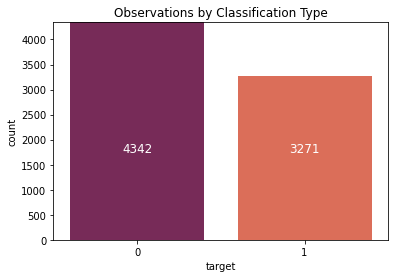

In [38]:
#CREDIT TO SOURCES: 
#https://stackoverflow.com/questions/28931224/adding-value-labels-on-a-matplotlib-bar-chart 

#explore distribution of dataset 

sns.countplot(x = train_data['target'], palette = 'rocket')
ax = plt.gca()
y_max = train_data['target'].value_counts().max() 
ax.set_ylim([0, round(y_max)])
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., 1700, '%d' % int(p.get_height()), 
            fontsize=12, color='white', ha='center', va= 'bottom')
plt.title("Observations by Classification Type")
plt.show()

In [39]:
#CREDIT TO SOURCE: https://stackoverflow.com/questions/35584085/how-to-count-duplicate-rows-in-pandas-dataframe
# look for duplication in dataset 

duplct_cnt = len(train_data['text'])-len(train_data['text'].drop_duplicates())
duplct_cnt

110

In [40]:
#CREDIT TO SOURCES: 
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.duplicated.html 

#create a flag for duplicate tweets
df = train_data
df['duplicate_tweet'] = np.where(df['text'].duplicated(keep=False), 'yes', 'no')
df

,id,keyword,location,text,target,duplicate_tweet
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,no
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,no
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,no
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,no
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,no
...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,no
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,yes
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,yes
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,yes


In [41]:
#look for most common duplicate tweet
df[df.duplicate_tweet == 'yes'].pivot_table(index='text', values='target', aggfunc='count').sort_values(by='target', ascending=False)


,target
text,
11-Year-Old Boy Charged With Manslaughter of Toddler: Report: An 11-year-old boy has been charged with manslaughter over the fatal sh...,10
He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam,6
The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.',6
#Bestnaijamade: 16yr old PKK suicide bomber who detonated bomb in ... http://t.co/KSAwlYuX02 bestnaijamade bestnaijamade bestnaijamade beÛ_,6
Madhya Pradesh Train Derailment: Village Youth Saved Many Lives,5
...,...
General News Û¢åÊ'Demolition of houses on waterways begins at Achimota Mile 7 ' via @233liveOnline. Full story at http://t.co/iO7kUUg1uq,2
Hellfire! We donÛªt even want to think about it or mention it so letÛªs not do anything that leads to it #islam!,2
Hellfire! We donÛªt even want to think about it or mention it so letÛªs not do anything that leads to it!,2


In [42]:
#check if duplicates are classified the same way

dups = df[df.duplicate_tweet == 'yes']
dups2 = dups[['id', 'text', 'target']].sort_values(by='text', ascending=False)
dups2

,id,text,target
5620,8018,wowo--=== 12000 Nigerian refugees repatriated ...,1
5641,8044,wowo--=== 12000 Nigerian refugees repatriated ...,0
6091,8698,that horrible sinking feeling when youÛªve be...,1
6123,8739,that horrible sinking feeling when youÛªve be...,1
6103,8714,that horrible sinking feeling when youÛªve be...,0
...,...,...,...
6377,9113,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
6373,9107,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
4312,6123,#Allah describes piling up #wealth thinking it...,1
4299,6105,#Allah describes piling up #wealth thinking it...,0


**Initial Observations:**

*   Dataset contains 7613 observations (i.e. rows) and 5 features (i.e. columns) 
*   Dataset contains missing values and spaces, indicated by NaN and %20 values  
*   There are 61 missing values under the keyword column 
*   There are 2533 missing values in the location column 
*   The training set shows an imbalance between classification types (i.e. tweet is/is not about a disaster) 
*   There are 110 duplicate tweets in the training set
*   Duplicate tweets are not always classified in the same way













In [43]:
#CREDIT TO SOURCES: 
#https://towardsdatascience.com/regex-essential-for-nlp-ee0336ef988d

#data cleaning 
def drop_dup(df): 
    #remove duplicates 
    df.drop_duplicates(subset=['text'], keep='first')
    return df

def text_clean(text):
  #remove line breaks
  text = re.sub(r"\n","",text)

  #convert to lowercase 
  text = text.lower()

  #remove digits and currencies 
  text = re.sub(r"\d+","",text) 
  text = re.sub(r'[\$\d+\d+\$]', "", text)      

  #remove dates 
  text = re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', text)
  text = re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', text)
  text = re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', text)

  #remove non-ascii
  text = re.sub(r'[^\x00-\x7f]',r' ',text) 

  #remove punctuation
  text = re.sub(r'[^\w\s]','',text) 

  #remove hyperlinks
  text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)

  #replace extra whitespaces with a single one 
  #text = re.sub(re.sub(' +', ' ', text)
  return text


train_data['clean_text'] = train_data['text'].apply(lambda x : text_clean(x))

In [57]:
#set up data for models 

filter_td = drop_dup(train_data)

num_test = int(train_data.shape[0] * 0.8)

dev_data, dev_labels = filter_td.text[num_test:], filter_td.target[num_test:]
train_d, train_l = filter_td.text[:num_test], filter_td.target[:num_test]


1523

In [65]:
#transform data
vectorizer = CountVectorizer(preprocessor=text_clean, stop_words='english')
vtrain = vectorizer.fit_transform(train_d)
vdev = vectorizer.transform(dev_data)


In [78]:
#produce logistic regression model
model_lr = LogisticRegression(C = 0.5, solver="liblinear", multi_class="auto")
start_time = time.time() 
model_lr.fit(vtrain, train_l)
train_predicted_labels_lr = model_lr.predict(vdev) 
stop_time = time.time()
total_time = stop_time - start_time
score_lr = metrics.f1_score(dev_labels, train_predicted_labels_lr, average='weighted')

score_lr, total_time

(0.7615959038539327, 0.03442025184631348)

In [77]:
#produce naive bayes model
nb_model = MultinomialNB()
start_time = time.time()  
nb_model.fit(vtrain, train_l)
nb_train_predicted_labels = nb_model.predict(vdev) 
stop_time = time.time()
total_time = stop_time - start_time
score_nb = metrics.f1_score(dev_labels, nb_train_predicted_labels, average='weighted')
score_nb, total_time

(0.7638446993948937, 0.005049943923950195)